```{currentmodule} tskit
```

In [1]:
import io
import pickle

import msprime
import tskit

def tables_examples():
    nodes = """\
    id      is_sample   time
    0       1           0
    1       1           0
    2       1           0
    3       0           0.15
    4       0           0.6
    5       0           0.8
    6       0           1.0
    """
    edges = """\
    left    right   parent  child
    20      80      3       0
    20      80      3       2
    0       100     4       1
    0       20      4       2
    80      100     4       2
    20      80      4       3
    80      100     5       0
    80      100     5       4
    0       20      6       0
    0       20      6       4
    """
    sites = """\
    id    position    ancestral_state
    0     15          A
    1     42          G
    2     60          T
    """
    mutations = """\
    site    node    derived_state    parent    time
    0       4       G                -1        0.9
    1       1       A                -1        0.4
    2       3       C                -1        0.55
    2       0       T                2         0.1
    """
    ts = tskit.load_text(
        nodes=io.StringIO(nodes),
        edges=io.StringIO(edges),
        strict=False,
    )
    ts.dump("data/tables_example.trees")
    ts = tskit.load_text(
        nodes=io.StringIO(nodes),
        edges=io.StringIO(edges),
        sites=io.StringIO(sites),
        mutations=io.StringIO(mutations),
        strict=False,
    )
    ts.dump("data/tables_example_muts.trees")

def construction_example():
    nodes = """\
    id      is_sample   time
    0       1           0
    1       1           0
    2       0           10
    3       1           0
    4       0           20
    """
    edges = """\
    left    right   parent  child
    0       1000    2       0
    0       1000    2       1
    0       1000    4       2
    0       1000    4       3
    """
    sites = """\
    id    position    ancestral_state
    0     500          A
    """
    mutations = """\
    site    node    derived_state    parent
    0       3       G                -1
    """
    ts = tskit.load_text(
        nodes=io.StringIO(nodes),
        edges=io.StringIO(edges),
        sites=io.StringIO(sites),
        mutations=io.StringIO(mutations),
        strict=False,
    )
    ts.dump("data/construction_example.trees")
    

def create_notebook_data():
    tables_examples()
    construction_example()

# create_notebook_data()  # uncomment to recreate the tree seqs used in this notebook

(sec_data_structures)=

# Data structures

(sec_data_structures_tables)=

## Tables

Internally, a tree sequence can be thought of as a set of tables, and {program}`tskit`
provides an interface for dealing with these tables directly. This is particularly
relevant when you wish to {ref}`edit or otherwise modify<sec_data_structures_editing>`
a tree sequence, although tables are also useful for bulk access to data contained in
the tree sequence, such as the times of all nodes.

There are eight tables that together define a tree sequence, although some may be empty,
and together they form a {class}`TableCollection`.
The tables are defined in the official {program}`tskit` documentation for
{ref}`Table Definitions <tskit:sec_table_definitions>`, and the
{ref}`Tables API <tskit:sec_tables_api>` section in the docs describes how to work with
them. In this tutorial we give some pointers about what you can and cannot do with them.

### Correspondance between tables and trees

Consider the following sequence of trees:

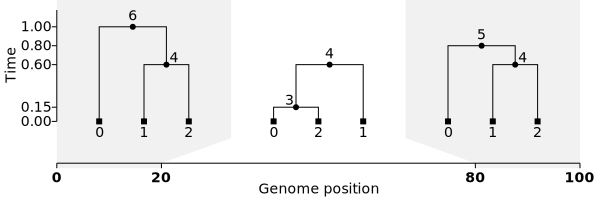

In [2]:
from IPython.display import SVG
ts = tskit.load("data/tables_example.trees")
SVG(ts.draw_svg(y_axis=True))

Ancestral recombination events have produced three different trees
that relate the three sampled genomes ``0``, ``1``, and ``2`` to each other
along the chromosome of length 100.

#### Node and edge tables

Each node in each of the above trees represents a particular ancestral genome
(a *haploid* genome; diploid individuals would be represented by two nodes).
Details about each node, including the time it lived, are stored in a
{class}`NodeTable` (details {ref}`here<tskit:sec_mutation_table_definition>`)

In [3]:
ts.tables.nodes

id,flags,population,individual,time,metadata
0,1,-1,-1,0.00000000,b''
1,1,-1,-1,0.00000000,b''
2,1,-1,-1,0.00000000,b''
3,0,-1,-1,0.15000000,b''
4,0,-1,-1,0.60000000,b''
5,0,-1,-1,0.80000000,b''
6,0,-1,-1,1.00000000,b''


Importantly, the first column, ``id``, is not actually recorded, and is
only shown when printing out node tables (as here) for convenience.
The second column, ``flags`` records a ``1`` for the individuals that are *samples*,
i.e., whose entire genealogical history is recorded by these trees.
(Note that the trees above record that node 3 inherited from node 4
on the middle portion of the genome, but not on the ends.)

The way the nodes are related to each other (i.e. the tree topology) is stored
in an {class}`EdgeTable` (details {ref}`here<tskit:sec_edge_table_definition>`).
Since some edges are present in more than one tree (e.g., node 1 inherits from node 4
across the entire sequence), each edge contains not only the IDs of a parent and a child
node, but also the left and right positions which define the genomic region for which it
appears in the trees:

In [4]:
ts.tables.edges

id,left,right,parent,child,metadata
0,20.00000000,80.00000000,3,0,b''
1,20.00000000,80.00000000,3,2,b''
2,0.00000000,100.00000000,4,1,b''
3,0.00000000,20.00000000,4,2,b''
4,80.00000000,100.00000000,4,2,b''
5,20.00000000,80.00000000,4,3,b''
6,80.00000000,100.00000000,5,0,b''
7,80.00000000,100.00000000,5,4,b''
8,0.00000000,20.00000000,6,0,b''
9,0.00000000,20.00000000,6,4,b''


Since node 3 is most recent, the edge that says that nodes 0 and 2 inherit
from node 3 on the interval between 0.2 and 0.8 comes first.  Next are the
edges from node 4: there are four of these, as the edge from node 4 to node
1 is shared across the entire sequence, and for each of the three
genomic intervals there is an additional child node. At this
point, we know the full tree on the middle interval.  Finally, edges
specifying the common ancestor of 0 and 4 on the remaining intervals (parents 6
and 5 respectively) allow us to construct all trees across the entire interval.



#### Sites and mutations tables

Most tree sequences have DNA variation data associated with them,
{ref}`stored as mutations overlaid on the trees<sec_what_is_dna_data>`:

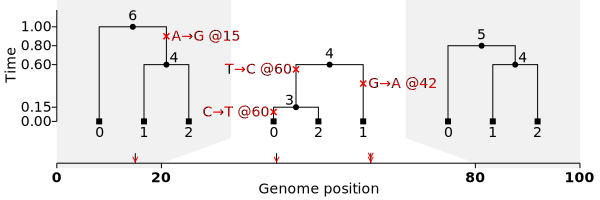

In [5]:
ts = tskit.load("data/tables_example_muts.trees")
mut_labels = {}  # An array of labels for the mutations, listing position & allele change
for mut in ts.mutations():  # This entire loop is just to make pretty labels
    site = ts.site(mut.site)
    older_mut = mut.parent >= 0  # is there an older mutation at the same position?
    prev = ts.mutation(mut.parent).derived_state if older_mut else site.ancestral_state
    mut_labels[mut.id] = "{}→{} @{:g}".format(prev, mut.derived_state, site.position)

SVG(ts.draw_svg(y_axis=True, mutation_labels=mut_labels))

There are four mutations in the depiction above,
marked by red crosses: one above node ``4`` on the first tree which records an A to G
transition at position 15, another above node ``1`` in the second tree which records a G
to A transition at position 45, and the final two above nodes ``2`` and ``0`` recording
transitions, both at position 60, on the second tree. The positions are recorded in the
{class}`SiteTable` (details {ref}`here<tskit:sec_site_table_definition>`):

In [6]:
ts.tables.sites

id,position,ancestral_state,metadata
0,15.00000000,A,b''
1,42.00000000,G,b''
2,60.00000000,T,b''


As with node tables, the ``id`` column is **not** actually recorded, but is
implied by the position in the table.  The mutations themselves are recorded in the
{class}`MutationTable` (details {ref}`here<tskit:sec_mutation_table_definition>`).
This associates each mutation with a site ID, the ID of the node above which the
mutation occurs, the derived state to which the allele has mutated, and (optionally) a
time at which the mutation occured.

In [7]:
ts.tables.mutations

id,site,node,time,derived_state,parent,metadata
0,0,4,0.90000000,G,-1,b''
1,1,1,0.40000000,A,-1,b''
2,2,3,0.55000000,C,-1,b''
3,2,0,0.10000000,T,2,b''


Where there are multiple mutations at the same site, there can be mutations
stacked on top of each other. The "parent" column therefore contains the ID of the
mutation immediately above the current one at the same site, or -1 if there is no parent.

These sites and mutations allow us to calculate the DNA sequence, or haplotype, for each
of the sample nodes:

In [8]:
for sample, h in enumerate(ts.haplotypes()):
    print(f"Sample {sample}: {h}")

Sample 0: AGT
Sample 1: GAT
Sample 2: GGC


#### Other tables

The other tables in a {class}`TableCollection` are the {class}`IndividualTable` (which
records which {ref}`individual organism<sec_nodes_or_individuals>` a node is contained
in), the {class}`PopulationTable` and the {class}`MigrationTable`, and the
{class}`ProvenanceTable` which records the {ref}`tskit:sec_provenance` of the data in
a tree sequence. These won't be covered in this tutorial.

#### Metadata

You may have noticed ``metadata`` columns in all the tables above. All tables can have
(optional) metadata attached to their rows, as described in the {ref}`sec_metadata`
section of the official {program}`tskit` documentation.
The {ref}`metadata tutorial<sec_tutorial_metadata>` provides more information about how
to set and use these metadata columns in tree sequence tables.


### Accessing table data

To look at a the contents of a table, you can simply `print` it:

In [9]:
print(ts.tables.mutations)

╔══╤════╤════╤══════════╤═════════════╤══════╤════════╗
║id│site│node│time      │derived_state│parent│metadata║
╠══╪════╪════╪══════════╪═════════════╪══════╪════════╣
║0 │   0│   4│0.90000000│            G│    -1│     b''║
║1 │   1│   1│0.40000000│            A│    -1│     b''║
║2 │   2│   3│0.55000000│            C│    -1│     b''║
║3 │   2│   0│0.10000000│            T│     2│     b''║
╚══╧════╧════╧══════════╧═════════════╧══════╧════════╝



But {program}`tskit` also provides access to the rows and columns of each table.

#### Row access

Rows can be accessed using square braces, which will return an object containing the
raw values:

In [10]:
row = ts.tables.mutations[1]
print(f"A mutation at site {row.site} exists at time {row.time}")
print(row)

A mutation at site 1 exists at time 0.4
MutationTableRow(site=1, node=1, derived_state='A', parent=-1, metadata=b'', time=0.4)


Additionally, many rows can be extracted into a new table using slices or
{ref}`numpy indexing<numpy:basics.indexing>`

In [11]:
ts.tables.mutations[2:4]

id,site,node,time,derived_state,parent,metadata
0,2,3,0.55000000,C,-1,b''
1,2,0,0.10000000,T,2,b''


:::{note}
When manipulating table data, it is quite possible to create a table collection that
does not correspond to a valid tree sequence. For instance, if we replaced the mutations
table in our original tree sequence with the table above, the parent column
would refer to an invalid mutation ID (ID 2, when in the new tables we only have
mutations with IDs 0 and 1). In this particular case there is a method,
{meth}`TableCollection.compute_mutation_parents`, which will recalculate the parent IDs
from the trees, but there is no general way to ensure that a manipulated table will
remain valid.
:::

Rows can also be *added* to a table using ``.add_row()``. However, when modifying tables
from a tree sequence, you should always modify a *copy* of the original data,
using the {meth}`TreeSequence.dump_tables` method:

In [12]:
new_tables = ts.dump_tables()
new_pos = 10
new_site_id = new_tables.sites.add_row(position=new_pos, ancestral_state="G")
print("New empty site allocated at position {new_pos} with ID {new_site_id}")
new_tables.sites

New empty site allocated at position {new_pos} with ID {new_site_id}


id,position,ancestral_state,metadata
0,15.00000000,A,b''
1,42.00000000,G,b''
2,60.00000000,T,b''
3,10.00000000,G,b''


Note that one of the requirements of a tree sequence is that the sites are listed in
order of position, so this new table will require sorting (see
{ref}`sec_data_structures_tables_creating`)


#### Column access

An entire column in a table can be extracted as a {program}`numpy` array from the table
object. For instance, if ``n`` is a {class}`NodeTable`, then ``n.time``
will return an array containing the birth times of the individuals whose genomes
are represented by the nodes in the table. *However*, it is important to note that this
is a copy of the data, and modifying individual elements of ``n.time`` will *not* change
the node table ``n``. To change the column data, you need to take a copy, modify it,
and assign it back in. For example, here we add 0.25 to every ``time`` except the first
in the node table from our current example:

In [13]:
node_table = new_tables.nodes
times = node_table.time
print("Old node times:", times)
times[1:] = times[1:] + 0.25
node_table.time = times
node_table

Old node times: [0.   0.   0.   0.15 0.6  0.8  1.  ]


id,flags,population,individual,time,metadata
0,1,-1,-1,0.00000000,b''
1,1,-1,-1,0.25000000,b''
2,1,-1,-1,0.25000000,b''
3,0,-1,-1,0.40000000,b''
4,0,-1,-1,0.85000000,b''
5,0,-1,-1,1.05000000,b''
6,0,-1,-1,1.25000000,b''


When assigning columns like this, an error will be raised if the column is not of the
expected length:

In [14]:
node_table.time = times[2:]

ValueError: Input array dimensions must be equal.

(sec_data_structures_tables_creating)=

### Turning tables into a tree sequence

The {meth}`TableCollection.tree_sequence` method will attempt to turn a table collection
into a tree sequence. This is not guaranteed to work: it's possible you have created a
nonsensical tree sequence where, for example, a child node has multiple parents at
a given position. The {ref}`tskit:sec_valid_tree_sequence_requirements` section of the
official tskit docs lists the requirements; these include the correct order for rows in
a number of tables. For instance, the sites table is
{ref}`required<tskit:sec_site_requirements>` to be sorted in order of position. Since
this is not true of the sites table in the ``new_tables`` collection we have just
created, we need to {meth}`~TableCollection.sort` the table collection before turning
it into a tree sequence

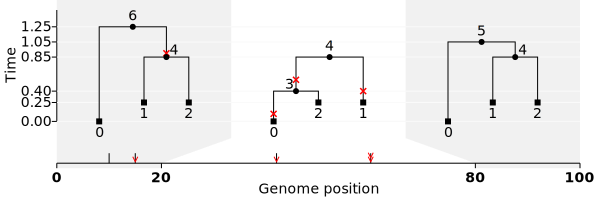

In [15]:
# new_ts = new_tables.tree_sequence()  # This won't work
new_tables.sort()
new_ts = new_tables.tree_sequence()  # Now it will
# Plot without mutation labels, for clarity 
SVG(new_ts.draw_svg(y_axis=True, y_gridlines=True, mutation_labels={}))

Here you can see that a new empty site has been added at position 10 (represented by a
tickmark above the X axis with no mutations on it), and all the nodes except node 0
have had their times increased by 0.25.

### Constructing a tree sequence

With the tools above in mind, we can now see how to construct a tree sequence by hand.
It's unlikely that you would ever need to do this from scratch, but it's helpful to
understand how tables work. We'll build the simplest possible tree sequence, a single
tree that looks like this:

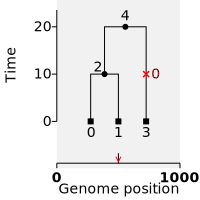

In [16]:
SVG(tskit.load("data/construction_example.trees").draw_svg(y_axis=True))

Starting with an empty set of tables, we can fill, say, the node information by using
{meth}`NodeTable.add_row` as follows:

In [17]:
tables = tskit.TableCollection(sequence_length=1e3)
node_table = tables.nodes  # set up an alias, for efficiency
node_table.add_row(flags=tskit.NODE_IS_SAMPLE)  # Node 0: defaults to time 0
node_table.add_row(flags=tskit.NODE_IS_SAMPLE)  # Node 1: defaults to time 0
node_table.add_row(time=10)  # Node 2: not a sample
node_table.add_row(flags=tskit.NODE_IS_SAMPLE)  # Node 3
node_table.add_row(time=20)  # Node 4
node_table

id,flags,population,individual,time,metadata
0,1,-1,-1,0.00000000,b''
1,1,-1,-1,0.00000000,b''
2,0,-1,-1,10.00000000,b''
3,1,-1,-1,0.00000000,b''
4,0,-1,-1,20.00000000,b''


The ``.add_row()`` method is natural (and should be reasonably efficient) if
new records appear one-by-one. Alternatively ``.set_columns()`` can be used to
set columns for all the rows at once, by passing in numpy arrays of the appropriate
type. We'll use that for the edges:

In [18]:
import numpy as np
edge_table = tables.edges
edge_table.set_columns(
    left=np.array([0.0, 0.0, 0.0, 0.0]),
    right=np.array([1e3, 1e3, 1e3, 1e3]),
    parent=np.array([2, 2, 4, 4], dtype=np.int32),  # References IDs in the node table
    child=np.array([0, 1, 2, 3], dtype=np.int32),  # References IDs in the node table
)
edge_table

id,left,right,parent,child,metadata
0,0.00000000,1000.00000000,2,0,b''
1,0.00000000,1000.00000000,2,1,b''
2,0.00000000,1000.00000000,4,2,b''
3,0.00000000,1000.00000000,4,3,b''


And finally we can add a site and a mutation: here we'll use 0/1 mutations rather than
ATGC.

A hand-built tree sequence!


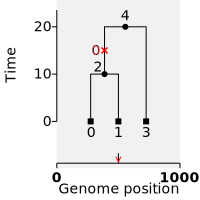

In [19]:
site_id = tables.sites.add_row(position=500.0, ancestral_state='0')
tables.mutations.add_row(site=site_id, node=2, derived_state='1')
ts = tables.tree_sequence()
print("A hand-built tree sequence!")
SVG(ts.draw_svg(y_axis=True))

:::{note}
The ordering requirements for a valid tree sequence
{ref}`do not specify<tskit:sec_node_requirements>` that rows in the
node table have to be sorted in any particular order, e.g. by time. By convention,
sample nodes are often the first ones listed in the node table, and this is the node
order returned by {meth}`~TreeSequence.simplify`, but the example above shows that
sample nodes need not necessarily be those with the IDs $0..n$.
:::

(sec_data_structures_editing)=

## Editing tree sequences

Sometimes we wish to make some minor modifications to a tree sequence that has
been generated by a simulation. However, tree sequence objects are **immutable**
and so we cannot edit them in place.


Several {program}`tskit` methods will return a new tree sequence that has been
modified in some way. For example:
- {meth}`TreeSequence.delete_sites` returns a tree sequence with certain sites
  deleted
- {meth}`TreeSequence.delete_intervals` and {meth}`TreeSequence.keep_intervals` 
  return a tree sequence whose trees cover a smaller fraction of the genome (and which can
  be combined with {meth}`TreeSequence.trim` to change the coordinate system)
- {meth}`TreeSequence.simplify` returns a new tree sequence with some sample nodes removed
  (see the {ref}`simplification tutorial<sec_simplification>`).
- {meth}`TreeSequence.union` returns a new tree sequence formed by merging two other tree
  sequences together.

However, if you want to do something not covered by those built-in methods, you will
need to edit a copy of the underlying tables and then create a new tree sequence from
the modified tables. In the following example, we use this
approach to remove all singleton sites from a given tree sequence.

In [20]:
def strip_singletons(ts):
    tables = ts.dump_tables()
    tables.sites.clear()
    tables.mutations.clear()
    for tree in ts.trees():
        for site in tree.sites():
            assert len(site.mutations) == 1  # Only supports infinite sites muts.
            mut = site.mutations[0]
            if tree.num_samples(mut.node) > 1:
                site_id = tables.sites.append(site)
                mut = mut.replace(site=site_id)  # set the new site id
                tables.mutations.append(mut)
    return tables.tree_sequence()

This function takes a tree sequence containing some infinite sites mutations as
input, and returns a copy in which all singleton sites have been removed.
The approach is very simple: we get a copy of the underlying
table data in a {class}`TableCollection` object, and first clear the
site and mutation tables. We then consider each site in turn,
and if the number of samples with
the mutation is greater than one, we add the site and mutation to our
output tables using {meth}`SiteTable.append` and {meth}`MutationTable.append`. These
functions act exactly like {meth}`SiteTable.add_row` and {meth}`MutationTable.add_row`
but they take an existing site or mutation and add all its details as a new row.


:::{note}
In this code we consider only simple infinite sites mutations,
where we cannot have back or recurrent mutations. These would require a slightly
more involved approach where we keep a map of mutation IDs so that
mutation ``parent`` values could be computed.
:::

After considering each site, we then create a new tree sequence using
the {meth}`TableCollection.tree_sequence` method on our updated tables.
We can test this on a tree sequence that has been mutated using
{func}`msprime.sim_mutations` with the ``discrete_genome``
parameter set to ``False``, which creates infinite sites mutations:

In [21]:
import msprime

ts = msprime.sim_ancestry(10, random_seed=123)
ts = msprime.sim_mutations(ts, rate=10, discrete_genome=False, random_seed=123)
print(ts.num_sites, "sites in the simulated tree sequence")

ts_new = strip_singletons(ts)
print(ts_new.num_sites, "sites after removing singletons")

109 sites in the simulated tree sequence
57 sites after removing singletons


:::{todo}
Add another example here where we use the array oriented API to edit
the nodes and edges of a tree sequence. Perhaps recapitating would be a
good example?
:::

(sec_data_structures_trees)=

## Trees

A {class}`Tree` represents a single tree in a {class}`TreeSequence`.
The {program}`tskit` Tree implementation differs from most tree libraries by
using **integer IDs** to refer to nodes rather than objects. Thus, when we wish to
find the parent of the node with ID '0', we use ``tree.parent(0)``, which
returns another integer. If '0' does not have a parent in the current tree
(e.g., if it is a root), then the special value {data}`tskit.NULL`
({math}`-1`) is returned. The children of a node are found using the
{meth}`Tree.children` method. To obtain information about a particular node,
one may either use ``tree.tree_sequence.node(u)`` to which returns the
corresponding {class}`Node` instance, or use the {attr}`Tree.time` or
{attr}`Tree.population` shorthands.

:::{todo}
Add an example of using the tree structure. Note that traversing through the
structure is covered in a different tutorial.
:::